**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 9**

**Problem 9.13**


**Assume a PV system is installed on the rooftop of a dwelling in Dakar, Senegal (14.7166$^{\circ}$N, 17.4676$^{\circ}$W). 
The system includes one PV panel LG290N1C (oriented towards the south) and one microinverter ABB-MICRO-0.25. For the cell temperature estimation, assume that the PV module is glass-glass, and mounted on the rooftop surface (close mount).
Use pvlib and the Typical Meteorological Year (TYM) to:**

**(a) find the optimum inclination for the PV generator that maximizes the reference yield $Y_R$**

**(b) find the optimum inclination for the PV generator that maximizes the final yield $Y_F$**

**Discuss the results.**

We will use the packages [pvlib](https://pvlib-python.readthedocs.io/en/stable/), [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results. We will also use the package [pytz](https://pypi.org/project/pytz/) to determine the time zone of Egypt.

In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pytz

We start by defining the location, date, and time. 

In [2]:
# Dakar, Senegal
lat, lon =  14.7166, -17.4676
altitude = 22

tz = pytz.country_timezones('SN')[0] # timezone corresponding to country 'EG' (Egypt)

# location
location = pvlib.location.Location(lat, lon, tz=tz)

orientation = 180 # pvlib sets orientation origin at North -> South=180

We retrieve typical meteorological year (TMY) data from PVGIS.

In [3]:
tmy, _, _, _ = pvlib.iotools.get_pvgis_tmy(latitude=lat, longitude=lon, map_variables=True)

tmy.index = tmy.index.tz_convert(tz) # use local time

We retrieve the PV modules and inverter specifications from the database at the [NREL SAM (System Advisory Monitoring)](https://sam.nrel.gov/). 


In [4]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['LG_LG290N1C_G3__2013_'] # module LG290N1C

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

For the temperature parameters, we assume a close mount glass-glass configuration. 

In [5]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm'] ['close_mount_glass_glass']

We calculate the Sun's coordinates 

In [6]:
# calculate Sun's coordinates
solar_position = location.get_solarposition(times=tmy.index)

We calculate the reference and final yields for different tilt angles.

In [7]:
#list of potential tilt angle
tilts=range(0,90,1)

Y_F = pd.Series(index=tilts, dtype=float)
Y_R = pd.Series(index=tilts, dtype=float)

for tilt in tilts: 
    # calculate irradiante at the plane of the array (poa)
    poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                           surface_azimuth=orientation,
                                                           dni=tmy['dni'],
                                                           ghi=tmy['ghi'],
                                                           dhi=tmy['dhi'],
                                                           solar_zenith=solar_position['apparent_zenith'],
                                                           solar_azimuth=solar_position['azimuth'])
    
    #save reference yield
    Y_R[tilt]=0.001*poa_irradiance['poa_global'].sum()

    #calculate airmass 
    airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    
    #calculate the angle of incidence (aoi)
    aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                               surface_azimuth=orientation,
                               solar_zenith=solar_position['apparent_zenith'],
                               solar_azimuth=solar_position['azimuth'])

    #calculate the effective irradiance
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(poa_irradiance['poa_direct'],
                                                                    poa_irradiance['poa_diffuse'],
                                                                    am_abs,
                                                                    aoi,
                                                                    module)
    #calculate the cell temperature
    cell_temperature = pvlib.temperature.sapm_cell(poa_irradiance['poa_global'],
                                                   tmy["temp_air"],
                                                   tmy["wind_speed"],
                                                   **temperature_model_parameters,)
    
    #calculate the DC and AC energy generation in every hour
    dc_power = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)

    ac_power = pvlib.inverter.sandia(dc_power['v_mp'], dc_power['p_mp'], inverter)

    #save the final yield
    P_STC=module['Impo']*module['Vmpo']

    Y_F[tilt] = ac_power.sum()/P_STC 


We can plot the reference yield and the final yield as a function of the tilt angle.

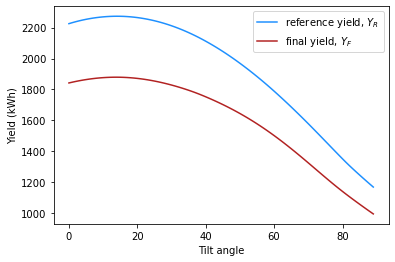

In [8]:
Y_R.plot(label="reference yield, $Y_R$", color='dodgerblue')
Y_F.plot(label="final yield, $Y_F$", color='firebrick')
plt.ylabel('Yield (kWh)')
plt.xlabel('Tilt angle')
plt.legend()

Both, the reference and final yields are maximized for a tilt angle of 14 degrees.

In [9]:
Y_R.idxmax()

14

In [10]:
Y_F.idxmax()

14